In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [3]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import starry
from scipy.optimize import minimize

starry.config.quiet = True

In [4]:
ydeg = 20
map = starry.Map(ydeg, lazy=False)

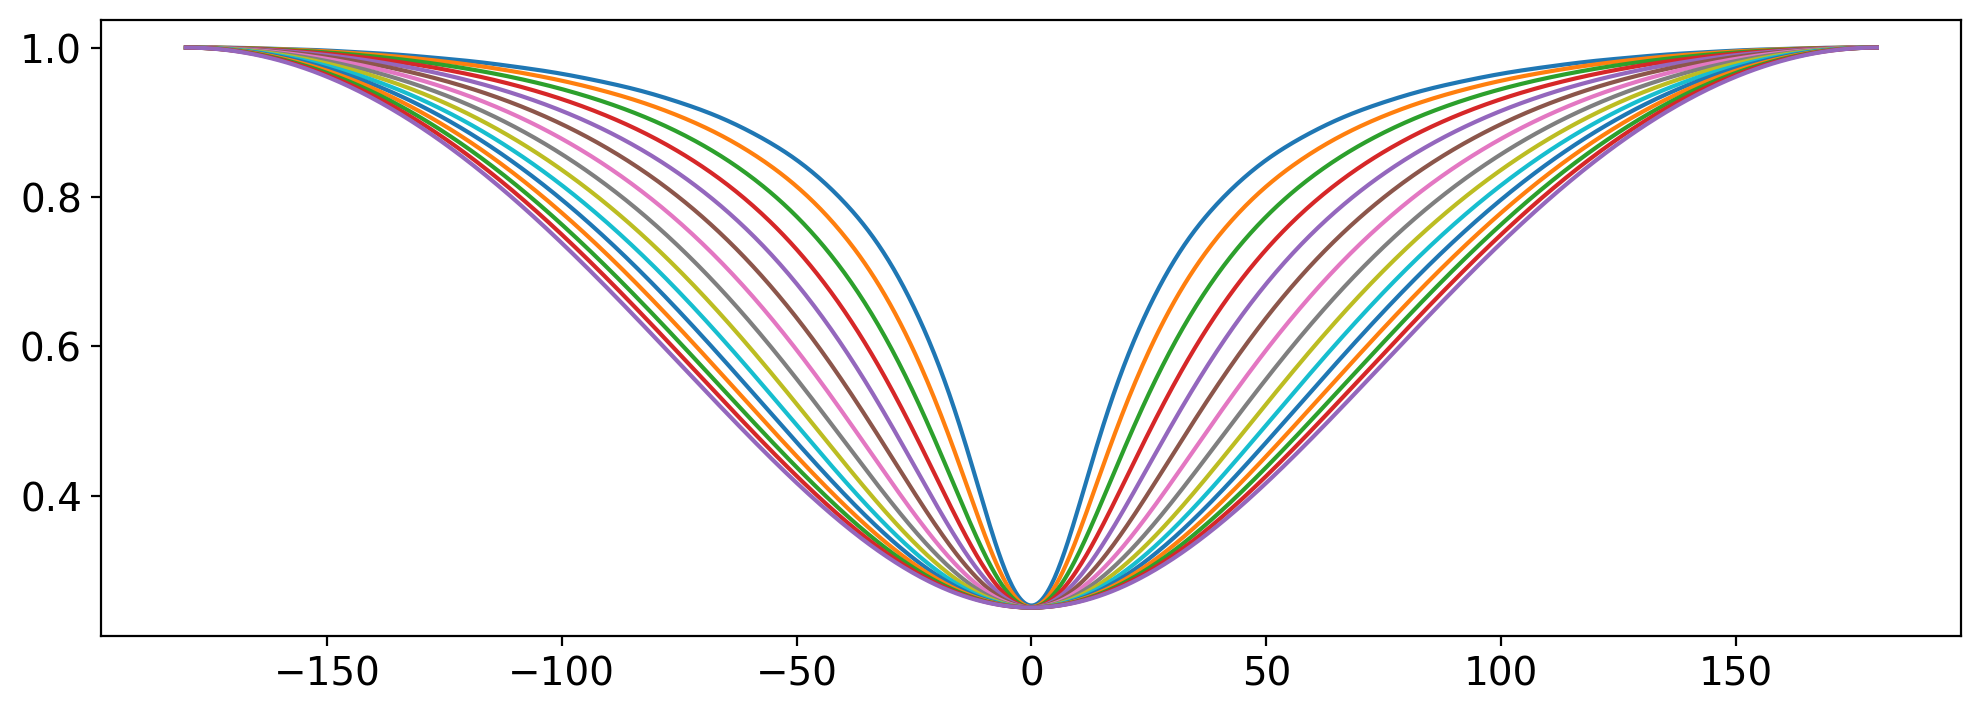

In [209]:
sigma = np.logspace(-0.5, 1, 15)
delta = 0.75
lon = np.linspace(-180, 180, 1000)

l = np.arange(1, map.ydeg + 1)

fig, ax = plt.subplots(1, figsize=(12, 4))
for k in range(len(sigma)):
    
    
    p = sigma[k]
    q = 1 + sigma[k]
    
    A = 1 - 0.5 * delta * p * q ** -1
    B = -delta / np.sqrt(2 * l + 1) * (
        q ** -(l + 1) * p
        +
        0.5 * q ** -(l + 1) * p ** 2
    )
    
    x = np.zeros(map.Ny)
    x[0] = A
    x[l * (l + 1)] = B
    
    map[:, :] = x
    ax.plot(lon, np.pi * map.intensity(lon=lon));

In [143]:
from scipy.stats import beta as Beta
from scipy.special import hyp2f1

In [145]:
alpha = 5.0
beta = 10.0
delta = 0.33

sigma = Beta.rvs(alpha, beta, size=100000)

l = 5
yl = -delta / np.sqrt(2 * l + 1) * (
        (1 + sigma) ** -(l + 1) * sigma
        +
        0.5 * (1 + sigma) ** -(l + 1) * sigma ** 2
    )
print(np.mean(yl))

-0.006613997189636624


In [149]:
-delta / np.sqrt(2 * l + 1) * alpha / (alpha + beta) * (
    hyp2f1(l + 1, alpha + 1, alpha + beta + 1, -1)
    + (alpha + 1) / (2 * (alpha + beta + 1)) * hyp2f1(l + 1, alpha + 2, alpha + beta + 2, -1)
)

-0.00661379202838334

In [152]:
hyp2f1(l + 1, alpha + 1, alpha + beta + 1, -1)

0.17211078490127005

In [153]:
(alpha + beta + 1 - l) / (2 * l) * hyp2f1(l - 1, alpha + 1, alpha + beta + 1, -1) - (
    2 * alpha + beta + 2 - 3 * l) / (2 * l) * hyp2f1(l, alpha + 1, alpha + beta + 1, -1)

0.17211078490127

In [154]:
from scipy.stats import lognorm as LogNormal

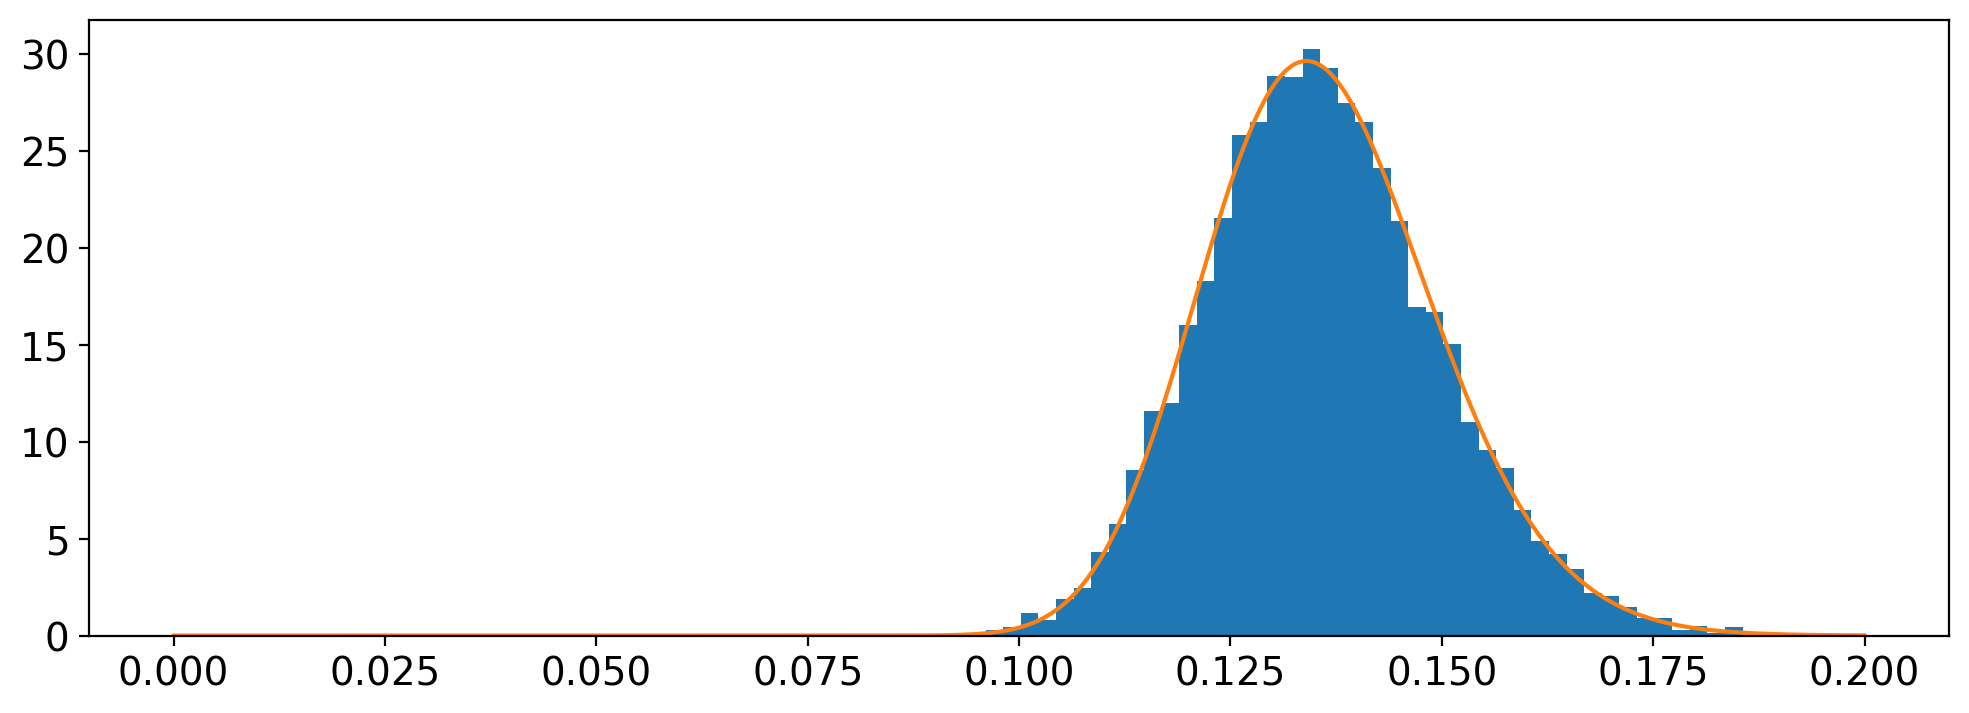

In [167]:
sigma = 0.1
mu = -2
Y = LogNormal.rvs(s=sigma, scale=np.exp(mu), size=10000)
X = 1 - Y
plt.hist(Y, bins=50, density=True)

y = np.linspace(0, 0.2, 1000)
plt.plot(y, LogNormal.pdf(y, s=sigma, scale=np.exp(mu)))

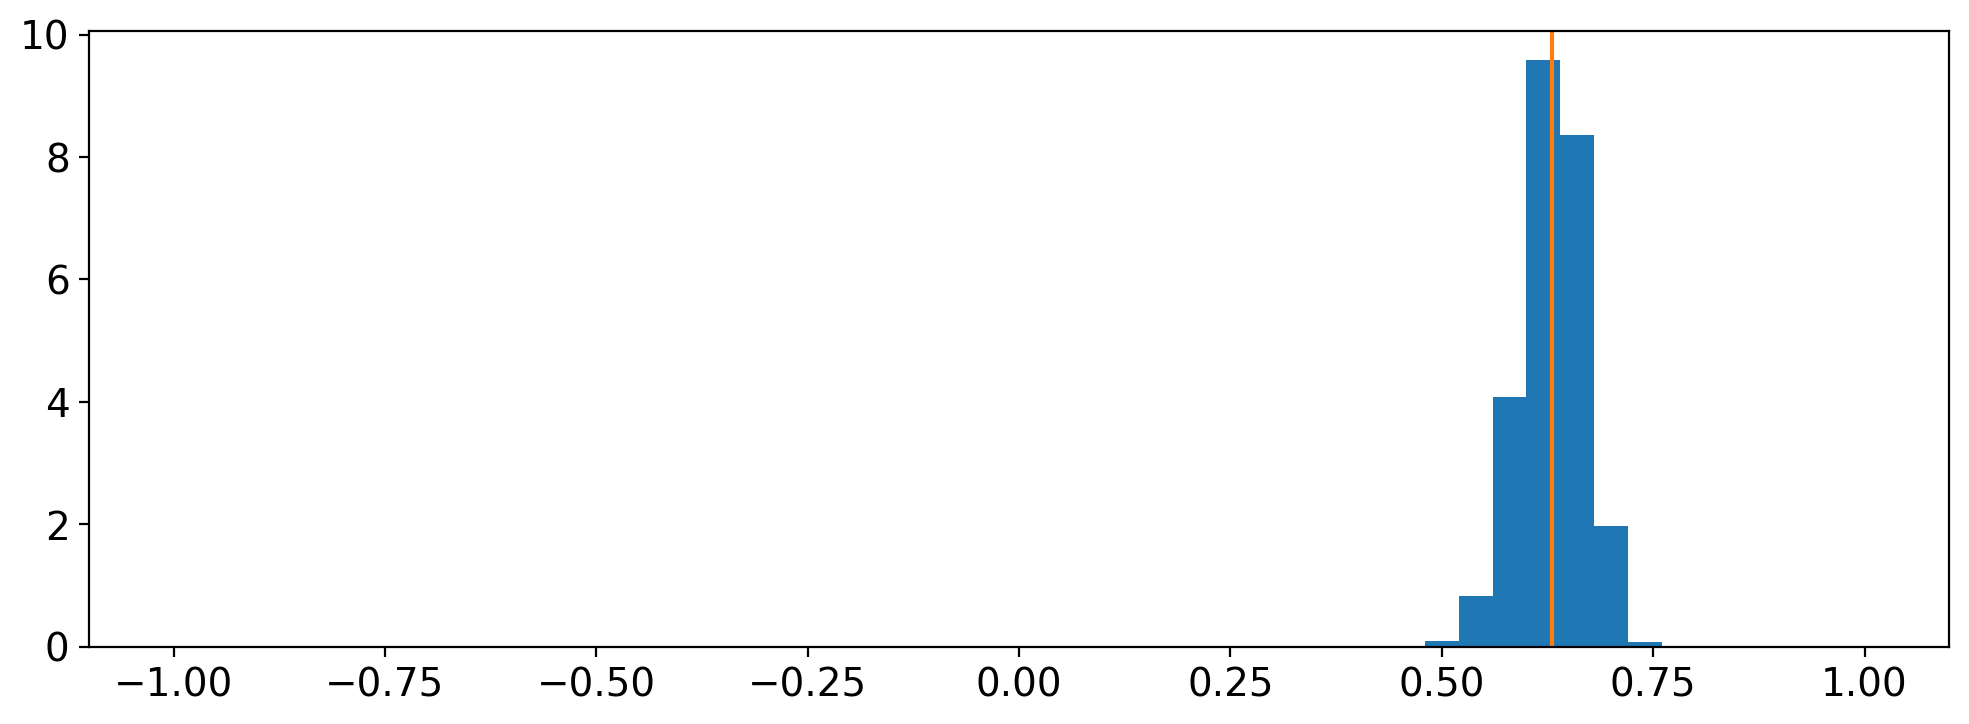

In [201]:
sigma = 0.1
mu = -1
Y = LogNormal.rvs(s=sigma, scale=np.exp(mu), size=100000)
X = 1 - Y
plt.hist(X, bins=50, density=True, range=(-1, 1));
plt.axvline(1 - np.exp(mu + 0.5 * sigma ** 2), color="C1")

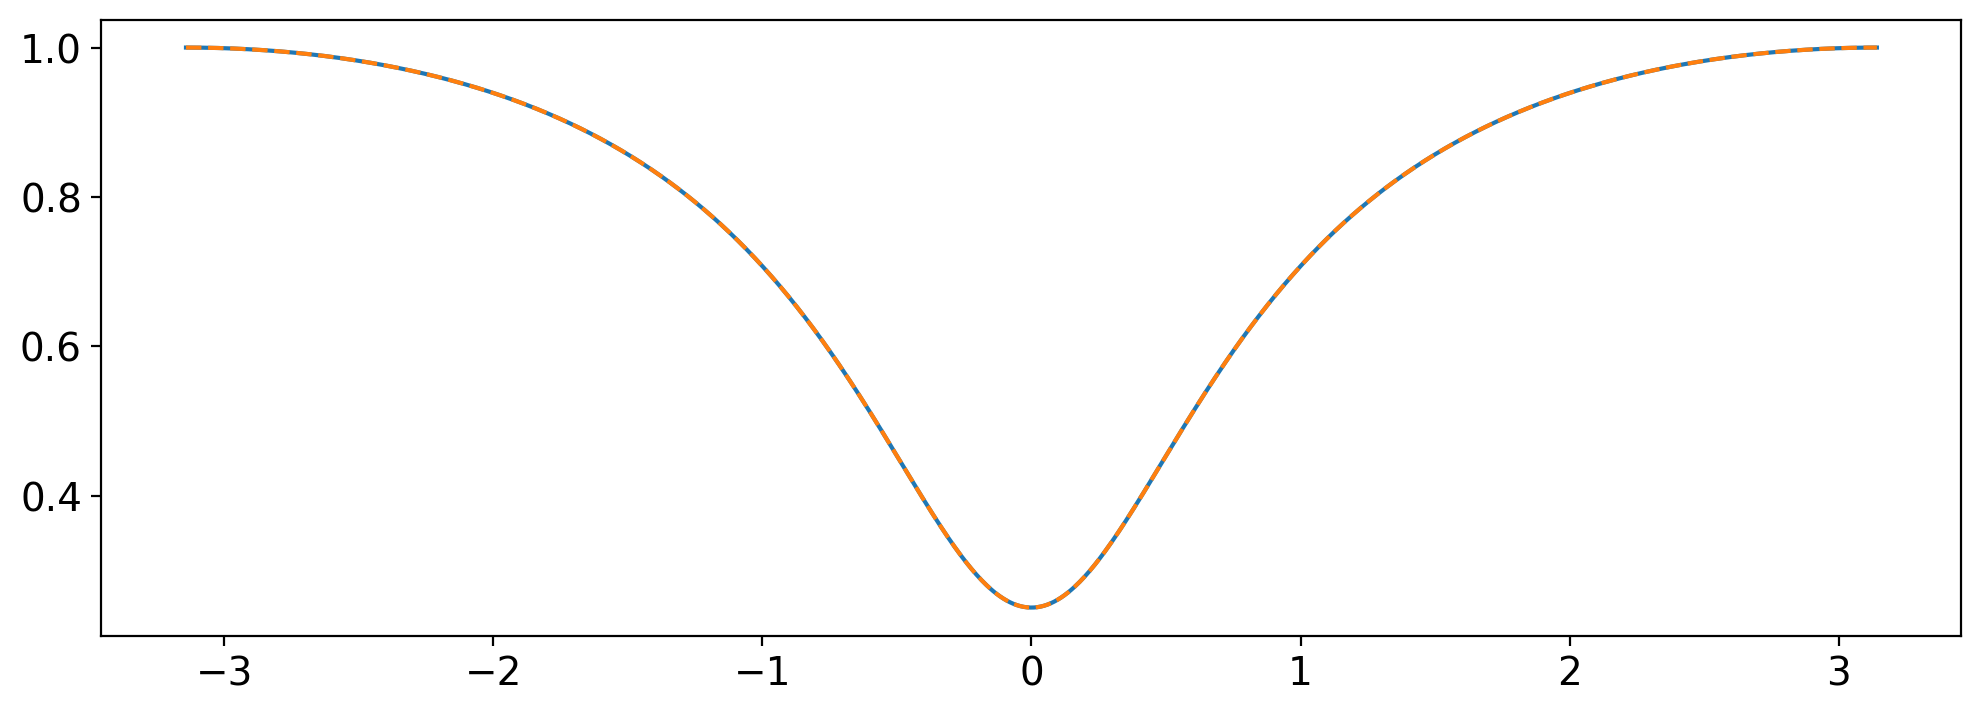

In [325]:
cr = 1.0
delta = 0.75
lon = np.linspace(-np.pi, np.pi, 1000)
coslon = np.cos(lon)
t = 1 / (1 + cr)

# Correct
term = 1 / np.sqrt(1 + t ** 2 - 2 * t * coslon)
A = 1 + delta * cr / 2
foo = A - delta * cr * (2 + cr) / 2 * t * (term)
plt.plot(lon, foo, "-")


A = 1 + delta * cr / 2
B = np.sqrt(1 / (8 + 8 * cr)) * delta * cr * (2 + cr)

C = (1 + (1 + cr) ** 2) / (2 + 2 * cr)
plt.plot(lon, A - B / np.sqrt(C - coslon), "--")